In [1]:
import uproot
import tensorflow as tf
import zfit
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import scipy
import math

/opt/anaconda3/envs/m2_req/lib/python3.10/site-packages/zfit/__init__.py:59: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [2]:
data = zfit.Data.from_root("mu2e_caloSimu_crySpec867_TTREE.root", "specTree", ["spec", "ratio", "ntrig", "stim", "time", "tErg"])
energy_unbinned = data["spec"]

In [3]:
print("Bin count calc: range / # of bins")
print("Bin count in order to keep y axis as events per 25keV is: ",(8-1.5)*1000/25)
print("Events per x keV once combined binning method is used: ", (8-1.5)*1000/212)

Bin count calc: range / # of bins
Bin count in order to keep y axis as events per 25keV is:  260.0
Events per x keV once combined binning method is used:  30.660377358490567


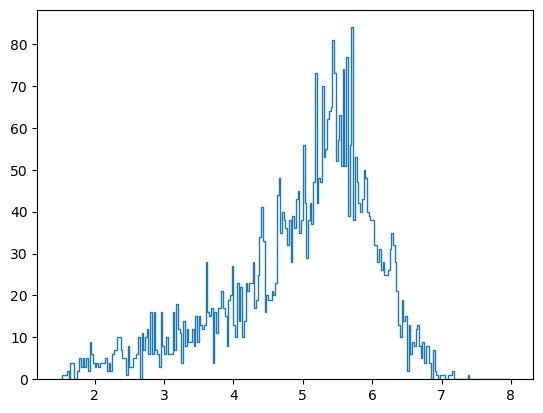

In [4]:
bin_count = 260
energy_binned, bin_location, patches = plt.hist(energy_unbinned,bins=bin_count,histtype='step',range=(1.5,8))

#### Parameters for 3 peaks

In [5]:
#parameters
cryspec = zfit.Space(['x'], limits=(1.5,8)) #obs range
ergElec = zfit.Parameter("electron energy", 0.511)
#ergElec = 0.511

fcbalpha = zfit.Parameter("fcbalpha", 2.5, 0.05, 20.0);
fcbndeg = zfit.Parameter ("fcbndeg", 10, 0.25, 80.);
A = zfit.Parameter ("A constant", 0.0169, 0.0149, 0.0189);
B = zfit.Parameter ("B constant", 0.01, 0.005, 0.04);

#Function to multiply paramers together for zfit.ComposedParameter
#def mult_list(params):
#    return params[0] * params[1]
#total signal parameter 
#frsignal = zfit.Parameter("fraction of combined signal", 0.2)
Evnsignal = zfit.Parameter("fraction of combined signal", 1000,10,len(energy_unbinned))


#full Peak
fullPeak = zfit.Parameter( "full peak", 6, 5.6, 6.2); 
fullRes = np.sqrt(pow(A/pow((fullPeak/1000),0.25),2)) + (B)**2 + (0.15/fullPeak)**2 #fractional resolution
fullWidth = zfit.Parameter( "width of the full peak",fullPeak*fullRes ); 
EvnFull = zfit.Parameter("No. of Events in full peak", 400);

#frFull = zfit.Parameter("Fraction of full peak", 0.4);
#frFull_sig = zfit.ComposedParameter('Full Peak fraction in signal', mult_list,params=[frFull, frsignal])

#params for fst peak
#fstEsPeak =zfit.Parameter("first peak",fullPeak - ergElec) #fullPeak - ergElec
fstEsPeak = fullPeak - ergElec #fullPeak - ergElec

fstRes = np.sqrt(pow(A/pow((fstEsPeak/1000),0.25),2)) + (B)**2 + (0.15/fstEsPeak)**2 #fractional resolution
fstWidth = zfit.Parameter("width of first escape peak",fstEsPeak*fstRes); 
EvnFrst = zfit.Parameter("No. of Events in first escape peak", 200);

#frFrst = zfit.Parameter("Fraction of first escape peak", 0.3);
#frFrst_sig = zfit.ComposedParameter('First Peak fraction in signal', mult_list,params=[frFrst, frsignal])

#params for scnd peak
scdEsPeak = zfit.Parameter("second peak",fullPeak - 2*ergElec) #fullPeak - 2*ergElec
scdRes = np.sqrt(pow(A/pow((scdEsPeak/1000),0.25),2)) + (B)**2 + (0.15/scdEsPeak)**2 #fractional resolution
scdWidth = zfit.Parameter("width of second escape peak", scdEsPeak*scdRes);
EvnScd = zfit.Parameter("No. of Events in second escape peak", 300);
#1. either let it be a number and then add a constraint that says fll+1+2=total
# 2. or give it an equation to 

#frScd = zfit.Parameter("Fraction of second escape peak", (1-frFull-frFrst));
#frScd_sig = zfit.ComposedParameter('Second Peak fraction in signal', mult_list,params=[frScd, frsignal])


<zfit.Parameter 'full peak' floating=True value=6>
tf.Tensor(5.489, shape=(), dtype=float64)
<zfit.Parameter 'second peak' floating=True value=4.978>
5.489
4.978


#### Logistic background

In [50]:
#logistic background parameters
comCnst = zfit.Parameter("comCnst", 4, 1, 20)
combeta = zfit.Parameter("combeta", 1, 0.01, 30)
#EvnBG = zfit.Parameter("Fraction of logistic background",len(energy_unbinned)-Evnsignal)
EvnBG = zfit.Parameter("No. of Evns in logistic background",100)

#frBG = zfit.Parameter("Fraction of logistic background",1-frsignal)

In [7]:
class bckgrndPDF(zfit.pdf.ZPDF):
    _N_OBS = 1
    _PARAMS = ['comCnst3', 'combeta3']  # the name of the parameters

    def _unnormalized_pdf(self, x):
        x = zfit.z.unstack_x(x)
        comCnst = self.params['comCnst3']
        combeta = self.params['combeta3']
        return 1.0/(1.0+tf.math.exp((x-comCnst)/combeta))

#### Hand-made Crystal Ball func

In [127]:
# z = sign(alpha)*(x - mu)/sigma; 
# abs_alpha = abs(alpha);
# 
# test = z  > - abs_alpha;
# functionCB = test.*exp(- 0.5 * z.^2) + (~test).*(exp(-0.5*alpha^2)*(1-alpha^2/n-z*abs_alpha/n).^(-n));
alpha = zfit.Parameter("alpha", 2.5, 0.05, 20.0);
n = zfit.Parameter ("n", 10, 0.25, 80.);
sigma = zfit.Parameter( "sigma",fullPeak*fullRes);
mu = zfit.Parameter( "mu", 6, 5.6, 6.2);

class createdCB(zfit.pdf.ZPDF):
    _N_OBS = 1
    _PARAMS = ['alpha', 'n' ,'mu', 'sigma']  # the name of the parameters

    def _unnormalized_pdf(self, x):
        x = zfit.z.unstack_x(x)
        alpha = self.params['alpha']
        n = self.params['n']
        mu = self.params['mu']
        sigma = self.params['sigma']
        z=alpha*(x-mu)/sigma
        test = z>-abs(alpha)
        return test*np.exp(-0.5*(z**2))+(test)*(np.exp(-0.5*alpha**2))*((1-alpha**2)/(n-z*abs(alpha)/n))**(-n)


#### Range, Scale and Limits

In [8]:
lower, upper = cryspec.limits
x_range= cryspec.area()

#the pdfs below are normalised to =1 so must apply scaling factor 
scale = (len(energy_unbinned)/bin_count)*x_range

#TODO:: integrate from low bin edge to high bin edge instead of using bin center
bin_centers =  (bin_location[1:] + bin_location[:-1])/2

#normalisation factor incase # of events are used as the extended param in the pdf def instead of fractions 
#norm=1/(frFull+frFrst+frScd)
#print(norm)

#### PDF Definition

In [9]:
fullErg = zfit.pdf.CrystalBall(obs=cryspec, mu=fullPeak, sigma=fullWidth, alpha=fcbalpha, n=fcbndeg, extended=EvnFull)
#extended= frfull*frsignal does not work in the minimiser-- solution: make extended = # number pf events and when plotting pdf/total # events
firstErg = zfit.pdf.CrystalBall(obs=cryspec,mu=fstEsPeak,sigma=fstWidth,alpha=fcbalpha, n=fcbndeg, extended=EvnFrst)
secdErg = zfit.pdf.CrystalBall(obs=cryspec, mu=scdEsPeak, sigma=scdWidth, alpha=fcbalpha, n=fcbndeg, extended=EvnScd)
background = bckgrndPDF(obs=cryspec, comCnst3=comCnst,combeta3=combeta, extended = EvnBG)
comb_fit = zfit.pdf.SumPDF([fullErg,firstErg,secdErg,background],obs=cryspec,extended = True)

#look into defining own pdf//maybe this will help getting fractions 

#### Running PDF

In [120]:
y_plot_full = fullErg.pdf(bin_centers,norm_range=cryspec)
y_plot_first = firstErg.pdf(bin_centers,norm_range=cryspec)
y_plot_secd = secdErg.pdf(bin_centers,norm_range=cryspec)
y_plot_comb = comb_fit.pdf(bin_centers,norm_range=cryspec)
y_plot_logistic = background.pdf(bin_centers,norm_range=cryspec)

y_plot_createdCB = createdCB.pdf(bin_centers)

TypeError: BasePDF.pdf() missing 1 required positional argument: 'x'

<zfit.Parameter 'full peak' floating=True value=6>
<zfit.Parameter 'width of the full peak' floating=True value=0.3687>
tf.Tensor(0.06144739492176123, shape=(), dtype=float64)
<zfit.Parameter 'fcbalpha' floating=True value=2.5>
<zfit.Parameter 'fcbndeg' floating=True value=10>
---------------------------------------------------------------
tf.Tensor(5.489, shape=(), dtype=float64)
<zfit.Parameter 'width of first escape peak' floating=True value=0.3455>
---------------------------------------------------------------
<zfit.Parameter 'second peak' floating=True value=4.978>
<zfit.Parameter 'width of second escape peak' floating=True value=0.3217>


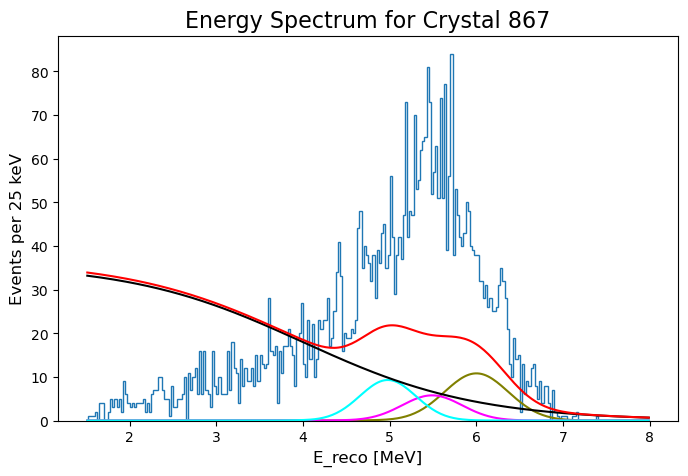

In [13]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.hist(energy_unbinned,bins=bin_count,histtype='step',range=(1.5,8))

plt.plot(bin_centers, y_plot_full*scale*EvnFull/len(energy_unbinned), color="olive", label='Full Peak CB')
plt.plot(bin_centers, y_plot_first*scale*EvnFrst/len(energy_unbinned), color="magenta",label='1st Esc Peak')
plt.plot(bin_centers, y_plot_secd*scale*EvnScd/len(energy_unbinned), color="cyan",label='2nd Esc Peak')
#logistic background
plt.plot(bin_centers, y_plot_logistic*scale*EvnBG/len(energy_unbinned), color="black", label='Full Peak CB')

#Combined Fit
plt.plot(bin_centers, y_plot_comb*scale, color="red",label='Combined Fit')


#chi sq goodness of fit test

#plt.text(2,60,"\u03C7\u00B2/ndf:"+str(round((comb_chisq[0]/(len(energy_binned))),2)),fontsize=14)
#plt.text(2,50,"p_value: "+str(round(comb_chisq[1],10)),fontsize=14)

plt.title("Energy Spectrum for Crystal 867", fontsize=16)
plt.ylabel('Events per 25 keV',fontsize=12)
plt.xlabel('E_reco [MeV]',fontsize=12)

#printing variables to see value before minimizer
print(fullPeak)
print(fullWidth)
print(fullRes)
print(fcbalpha)
print(fcbndeg)
print("---------------------------------------------------------------")
print(fstEsPeak)
print(fstWidth)
print("---------------------------------------------------------------")
print(scdEsPeak)
print(scdWidth)

#### Goodness of fit

In [ ]:
##TODO 

In [ ]:
#check to see if sum of binned data is accurate length of unbinned data

print("Sum of binned data:",np.sum(energy_binned))
print("Length of unbinned data",len(energy_unbinned))
alldata_integral = scipy.integrate.trapz(y_plot_comb*scale)
print("Integral of crystal ball fit =",alldata_integral)

In [108]:
#help(zfit.constraint)
#help(zfit.integrate)

In [104]:
constraint = zfit.core.constraint.SimpleConstraint(EvnFull+EvnFrst+EvnScd+EvnBG==4300,params=[EvnFull,EvnFrst,EvnScd,EvnBG])

nll_comb = zfit.loss.ExtendedUnbinnedNLL(model=comb_fit, data=energy_unbinned)#, constraints=constraint)

minimizer = zfit.minimize.Minuit()

result = minimizer.minimize(nll_comb, params=[A,B,fcbalpha,fcbndeg,
                                                  fullPeak,EvnFull,
                                                  EvnFrst,EvnScd,EvnBG,
                                                  comCnst,combeta])#there should be only 3 fr param- make frBG sum of others

#below are attempted methods to calculate erros
#param_hesse = result.errors()
#errors=zfit.minimizers.errors(result)
#errors=result.hesse(method='hesse_np', name='hesse')
#errors=result.hesse(method='minuit_hesse', name='hesse')
#errors = zfit.result.compute_erros(result,params=[A,B,fcbalpha,fcbndeg,fullPeak,frFull,frFrst,frBG,comCnst,combeta])

print(result)
print(fstEsPeak)
print(scdEsPeak)

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_2, Composed_autoparam_3, Composed_autoparam_4, Composed_autoparam_5]] data=[<zfit.Data: Data obs=('x',) shape=(4681, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  False  │    True     │       True       │ 4.6e-07 │        -28007.54 |  10008.12 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name                                   value  (rounded)    at limit
-----------------------------------  ------------------  ----------
A constant                                       0.0169       False
B constant                                         0.01       False
fcb

In [101]:
# running pdfs again to load the minimized values of params
y_plot_full = fullErg.pdf(bin_centers,norm_range=cryspec)
y_plot_first = firstErg.pdf(bin_centers,norm_range=cryspec)
y_plot_secd = secdErg.pdf(bin_centers,norm_range=cryspec)
y_plot_comb = comb_fit.pdf(bin_centers,norm_range=cryspec)
y_plot_logistic = background.pdf(bin_centers,norm_range=cryspec)

In [16]:
# combining binned data so that atleast 7 data points in each bin
combined_bins = []
current_bin = []

combined_edges = []
current_edge = []
left_edge = []
temp_bin = []
for (i,j) in zip(energy_binned,bin_location):
    current_bin.append(i)
    current_edge.append(j)

    if sum(current_bin)>=7:
        combined_bins.append(sum(current_bin[:]))
        combined_edges.append(current_edge.pop(0))
        current_edge.clear()
        current_bin.clear()
if current_bin:
    combined_bins.append(sum(current_bin[:])) 
    combined_edges.append(current_edge.pop(0))
    current_edge.clear()
    current_bin.clear()


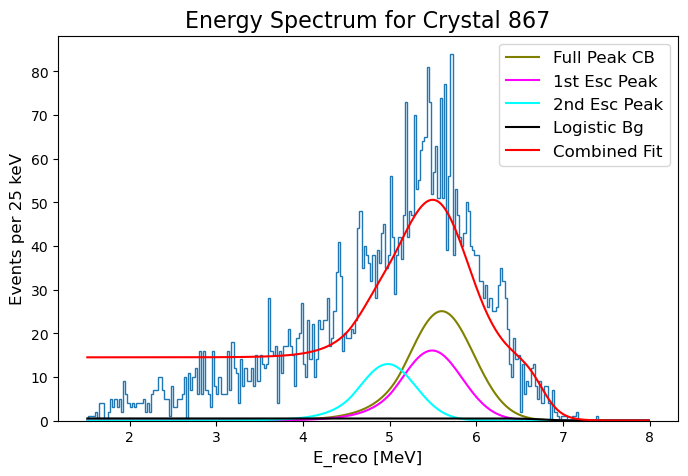

In [102]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
energy_binned, bin_location, patches = ax.hist(energy_unbinned,
                           bins=(bin_count),histtype='step',
                           range=(1.5,8))

plt.plot(bin_centers, y_plot_full*scale*EvnFull/len(energy_unbinned), color="olive", label='Full Peak CB')
plt.plot(bin_centers, y_plot_first*scale*EvnFrst/len(energy_unbinned), color="magenta",label='1st Esc Peak')
plt.plot(bin_centers, y_plot_secd*scale*EvnScd/len(energy_unbinned), color="cyan",label='2nd Esc Peak')
#logistic background
plt.plot(bin_centers, y_plot_logistic*scale*EvnBG/len(energy_unbinned), color="black", label='Logistic Bg')

#Combined Fit
plt.plot(bin_centers, y_plot_comb*scale, color="red",label='Combined Fit')


#adding text box with chi sq, pvalue and ndof 
#plt.text(1.5,70,"\u03C7\u00B2/ndf:"+str(round((comb_chisq_min[0]/(len(energy_binned))),2)),fontsize=14)
#plt.text(1.5,60,"ndf: "+str(round((len(energy_binned)),2)),fontsize=14)
#plt.text(1.5,50,"p_value: "+str(round(comb_chisq_min[1],10)),fontsize=14)

plt.title("Energy Spectrum for Crystal 867", fontsize=16)
plt.ylabel('Events per 25 keV',fontsize=12)
plt.xlabel('E_reco [MeV]',fontsize=12)
leg = plt.legend(fontsize=12);

#### Goodness of fit

In [84]:
## TODO

## Chi square formula from Frank's matlab file: chisqE0.m
binstart=combined_bins[0] #lower bound of binned energies-- just a number//not array
#binstart = 150;
binend=combined_bins[-1] #higher bound of binned energies-- should be using combined bins
#binend   = 230;
xlo=binstart 
#XLO = binstart-1. - pedCombine;      % Bins are counted starting at channel 1, for interval 0 to 1-- are we moving to the next bin?
xhi=binend
abg= combeta # should be expontential slope-- for now random number to test function
Abg = 1/(abg*(np.exp(-xlo/abg) - np.exp(-xhi/abg))); # difference between lower and upper values// integral of range-- some noramlisation factor
#work out the math of this integral ^ integral over logistic over whole fitted range
Asig = 1/np.sqrt(2*math.pi);

EBINS = np.array(combined_edges) #energies i nthe historgram
#EBINS = binstart-1:binend-1;
BINCONTENTS = combined_bins #use combined bins
#BINCONTENTS = yCombine(binstart:binend)' -- what is the '?
NSAMPLE = len(energy_unbinned) #total number of events

PRED = NSAMPLE*((1-(EvnBG/len(energy_unbinned)))*Asig*(((EvnFull/len(energy_unbinned))/fullWidth)*np.exp(-0.5*((EBINS-fullPeak)/fullWidth)**2)+ 
                              ((EvnFrst/len(energy_unbinned))/fstWidth)*np.exp(-0.5*((EBINS-fstEsPeak)/fstWidth)**2) + 
                              ((EvnScd/len(energy_unbinned))/scdWidth)*np.exp(-0.5*((EBINS-scdEsPeak)/scdWidth)**2))+ 
                              (EvnBG/len(energy_unbinned))*np.exp(-EBINS/abg)*Abg);



chisq = sum(((BINCONTENTS - PRED)**2)/BINCONTENTS);
#print(EvnBG/len(energy_unbinned))
#print(EvnFrst/len(energy_unbinned))
#print(PRED)
print(chisq)
##look for simple version files-- look at sourcespectrumfit.m

tf.Tensor(3154601.7208895218, shape=(), dtype=float64)


In [ ]:
##trying to get a array of the integral between each set of bins
integrated_bins = []
for x in bin_location:
    #integral.append(i)
    result.append(scipy.integrate.quad(x,bin_location[0],bin_location[1]))
    
print(x)


In [ ]:
#check to see if sum of binned data is accurate length of unbinned data
print("Sum of binned data:",np.sum(energy_binned))
print("Length of unbinned data",len(energy_unbinned)) 

#testing to see accuracy of which array of X's to use
y_plot_comb_edges = comb_fit.pdf(bin_location[:-1],norm_range=cryspec)
y_plot_comb_centers = comb_fit.pdf(bin_centers,norm_range=cryspec)
#y_plot_comb_integral = comb_fit.pdf(integrated_bins,norm_range=cryspec)

alldata_integral_edges = scipy.integrate.trapz(y_plot_comb_edges*scale) 
alldata_integral_centers = scipy.integrate.trapz(y_plot_comb_centers*scale)
#alldata_integral_integral = scipy.integrate.trapz(y_plot_comb_integral*scale)
# integral of fit should be done by zfit package-- should be more efficient/accurate
print("Integral of combined crystal ball fit, using bin edges =",alldata_integral_edges)
print("Integral of combined crystal ball fit, using bin centers =",alldata_integral_centers)
#print("Integral of combined crystal ball fit, using bin edge integral =",alldata_integral_integral)

#print(abs(alldata_integral-len(energy_unbinned)))

In [ ]:
y_plot_comb_combined = zfit.run(comb_fit.pdf(combined_edges,norm_range=cryspec))

scale_combined = (np.sum(combined_bins)/len(combined_bins))*(max(combined_edges)-min(combined_edges))


print("Sum of binned data:",np.sum(combined_bins))
combined_integral = scipy.integrate.trapz(y_plot_comb_combined*scale_combined)
print("Integral of combined crystal ball fit =",combined_integral)


In [ ]:
# plotting combined bin with the pdf to get a visual 
fig, ax = plt.subplots(1,1,figsize=(6,5))
plt.hist(combined_edges,bins=(combined_edges),weights=combined_bins,histtype='step',label= 'Energy Unbinned')

plt.plot(combined_edges, y_plot_comb_combined*scale_combined,color="black", label='Combined Bin Fit')
plt.plot(bin_centers, y_plot_comb*scale,color="red", label='Full Peak CB')

plt.title("Combined Bin Fit on Data ", fontsize=16)
plt.ylabel('Events per 30 keV',fontsize=12)
plt.xlabel('E_reco [MeV]',fontsize=12)
leg = plt.legend(fontsize=10);


In [ ]:

param1 = zfit.Parameter('param1', 1.0, 0.1, 1.8)
param2 = zfit.Parameter('param2', 42.0, 0, 100)

# using a dict for the params
def mult_dict(params):
    return params["a"] * params["b"]

mult_param_dict = zfit.ComposedParameter('mult_dict', mult_dict, params={"a": param1, "b": param2})

# using a list for the params
def mult_list(params):
    return params[0] * params[1]

mult_param_list = zfit.ComposedParameter('mult_list', mult_list, params=[param1, param2])

In [ ]:
print(mult_param_list)
print(mult_param_dict)